In [1]:
%matplotlib inline
import dtkFileTools as dtkt
import json
import sys
import snappy
import pandas as pd
import matplotlib
from pandas.io.json import json_normalize

# Load dtk serialized population data
dtk = dtkt.read(r'test-data\version2.dtk')

In [2]:
# Humans dataframe

# Rows for individual human with a subset of columns 
cols = ['suid.id', 'm_age', 'm_gender', 'm_is_infected', 'interventions.pSuccessfulFeedHuman']
df_humans = json_normalize(dtk.nodes[0].individualHumans, meta=['suid', 'id'])[cols]

# Add years and year group columns
df_humans.loc[:, 'age_y'] = df_humans['m_age']/365 
df_humans.loc[:, 'age_grp'] = df_humans['age_y'].apply(lambda r: 10*(int(r/10)) )

df_humans.head()

,suid.id,m_age,m_gender,m_is_infected,interventions.pSuccessfulFeedHuman,age_y,age_grp
0,1,7693.72,1,False,0.9,21.078685,20
1,2,17005.80,0,True,0.9,46.591233,40
2,3,5059.40,0,False,0.9,13.861370,10
3,4,27445.90,1,True,0.9,75.194247,70
4,5,5841.84,0,False,0.9,16.005041,10


In [3]:
# Report infected by age group
def report_infected_by_age_group(df_h, name):
    # Count by age group and infected status
    df_grp = df_h.groupby(['age_grp','m_is_infected'])[['age_y']].count()
    df_grp.columns = ['count']

    # pivot and plot (age group as rows, infected as cols)
    df_grp2 = df_grp.reset_index().pivot(index='age_grp', columns='m_is_infected', values='count')
    df_grp2 = df_grp2.fillna(0)
    df_grp2.plot.bar(title=name)
    #display(df_grp2.head())

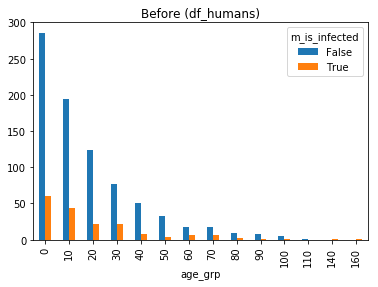

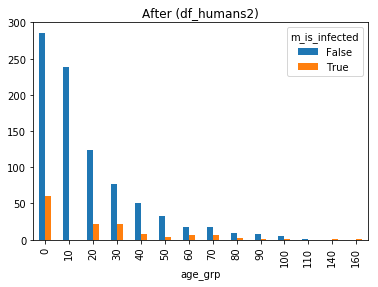

In [4]:
# Update infected in the dataframe

# Before: infected by age group
report_infected_by_age_group(df_humans, 'Before (df_humans)')

# Set all in the 10 age group NOT to be infected 
df_humans2 = df_humans.reset_index().set_index('suid.id')
df_humans2.loc[df_humans2.age_grp == 10, 'm_is_infected'] = False

# After: infected by age group
report_infected_by_age_group(df_humans2, 'After (df_humans2)')

In [5]:
# Update DTK object

# Before
print('Before')
#display(df_humans[df_humans.age_grp == 10].head())
print('dataframe, row #12: {}'.format(df_humans.loc[12].m_is_infected))
print('dtk obj, human #12: {}'.format(dtk.nodes[0].individualHumans[12].m_is_infected))


# Update m_is_infected for each human <-- NOT working at this point
for ind in dtk.nodes[0].individualHumans:  
    # Get human id 
    suid_id = ind['suid']['id']    
    # Read the infected value from the dataframe using human ID 
    m_is_infected = df_humans2.loc[suid_id].m_is_infected
    ind.m_is_infected = m_is_infected

print('')
print('After')
#display(df_humans2[df_humans2.age_grp == 10].head())
print('dataframe, row #12: {}'.format(df_humans2.loc[12].m_is_infected))
print('dtk obj, human #12: {}'.format(dtk.nodes[0].individualHumans[12].m_is_infected))

Before
dataframe, row #12: True
dtk obj, human #12: True

After
dataframe, row #12: False
dtk obj, human #12: True
